In [56]:
# import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot
from matplotlib import *
import pandas as pd
import numpy as np
import os.path
import csv
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics
import matplotlib.pyplot as plt

NAN_RATIO = 0.2 # Amount of NaN values to tolerate; otherwise, discard feature
NUM_TOP_CAUSES = 4 # Only this amount of the top causes will be used in the classification

In [3]:
df = pd.read_csv('Traffic_Collisions.csv')
N = len(df.index) # Number of data points
K = len(df.dtypes.index) # Number of features
df2 = filterForXGB(df)
df3 = getCommonCauses(df)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (21,37,51) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


['Unsafe Speed', 'Unknown', 'Auto R/W Violation', 'Improper Turning']


In [38]:
# Returns a list of tuples of (causeName, amount of occurrences of causeName) 
# sorted by the amount of occurrences of causeName in decreasing order
def getSortedCauses(df):
    causes = {}
    for index, row in df.iterrows():
        if row['Cause'] not in causes:
            causes[row['Cause']] = 1
        else:
            causes[row['Cause']] += 1
        sortedCauses = sorted(causes.items(), key=lambda x: x[1], reverse=True)
    return sortedCauses

# Return the data points of only the top NUM_TOP_CAUSES causes
def getCommonCauses(df):
    sortedCauses = getSortedCauses(df)
    topCauses = [None]*NUM_TOP_CAUSES
    for i in range(NUM_TOP_CAUSES):
        topCauses[i] = sortedCauses[i][0]
    print(topCauses)
    dropIndices = []
    for index, row in df.iterrows():
        if row['Cause'] not in topCauses:
            dropIndices.append(index)
    df = df.drop(dropIndices)
    return df
    
# Remove columns where there are many NaN values (based on NAN_RATIO)
def filterData(df):
    features = df.dtypes.index
    feature = df[features[2]]
    numNans = feature.isna().sum()
    keepFeatures = []
    for feature in features:
        featureData = df[feature]
        numNans = featureData.isna().sum()
        if numNans < NAN_RATIO*N:
            keepFeatures.append(feature)
    return df[keepFeatures]

# Filters the data for xgb use
def filterForXGB(df):
    df2 = df.drop(['OBJECTID', 'Accidno', 'Date', 'Street', 'CrossSt', 'X', 'Y', 'PtyAtFault', 
                   'PvtProp', 'Violation', 'PartyAge1', 'PartySex1', 'SafetyEq1', 'PartyAge2', 
                   'PartySex2', 'SafetyEq2', 'Distance'], axis=1)
    df3 = filterData(df2)
    df4 = df3.dropna()
    return df4

# Trains the XGB model for learning causes
def trainCauseModel(df, restart=False, modelName='xgbCause.model'):
    if not restart and os.path.isfile(modelName):
        bst = xgb.Booster()
        return bst.load_model(modelName)
    else:
        return trainXGB(df, modelName)

# Uses the onehot_encode method to encode an entire training data
def getEncodedTrainingData(df):
    # Onehot encode for each categorical feature and remember the label_encoder
    # The decodeDic should be useful in decoding the results
    decodeDic = {} # {key=featureName, value=(len(onehot_vector), label_encoder)}
    encodedTrain = None # Onehot encoded training data
    lenOfEncodes = {} # This will store the length of each one-hot encode for each feature
    for feature in df:
        if feature == 'Cause': # Skip this because it's the label we're trying to guess
            continue
        column = df[feature]
        if feature == 'Distance': # This doesn't need to be onehot encoded
            decodeDic[feature] = (1, None)
        elif feature == 'Time':
            column = roundTime(column)
        encoded, label_encoder, lenOfEncode = onehot_encode(column)   
        lenOfEncodes[feature] = lenOfEncode
        decodeDic[feature] = (len(encoded), label_encoder)
        encoded = np.array(encoded)
        
        if encodedTrain is None:
            encodedTrain = encoded
        else:
            encodedTrain = np.concatenate((encodedTrain, encoded), 1)
            
    return (encodedTrain, decodeDic, lenOfEncodes)
    
# Sets up the data to classify cause with XGB
def trainXGB(df, modelName):
    df = getCommonCauses(filterForXGB(df))
    
    # First remove all rows with cause=unknown
    dropIndices = []
    for index, row in df.iterrows():
        if row['Cause'] == "Unknown":
            dropIndices.append(index)
    df = df.drop(dropIndices)
    
    # Encode all the training data
#     print(df.shape)
    encodedTrainX, decodeDic, lenOfEncodes = getEncodedTrainingData(df)
#     print(encodedTrainX.shape)

    # May need to convert label for causes to one-hot encoding rather than integer_encoding later
    labelEncoder = LabelEncoder()
    integerEncodedY = np.array(labelEncoder.fit_transform(df['Cause']))
    
    # Split data into train and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(encodedTrainX, integerEncodedY, test_size=0.05)
#     print(X_train.shape)
    
    # Fit model to training data
    model = XGBClassifier()
    eval_set = [(X_test, Y_test)]
    model.fit(X_train, Y_train, eval_metric="mlogloss", eval_set=eval_set, verbose=False)
    
    # Make predictions for test data
    Y_pred = model.predict(X_test)
    predictions = [round(value) for value in Y_pred]
    
    # Evaluate predictions
    accuracy = accuracy_score(Y_test, predictions)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))  
    return (model, decodeDic, lenOfEncodes)

# Uses model to predict unknown causes based on information entered.
# Right now, this information is just taken from all the entries of the dataframe
# that have "unknown" as the cause.
# TODO: This needs work. The current problem is that since we are trying to predict
# on unknown causes, the data we are predicting has the same amount of features as before,
# but in these features, there are less different values, which would change the length
# of the one-hot encoding, which prevents us from using model.predict 
def predictUnknownCauses(model, df, decodeDic):
    df = getCommonCauses(filterForXGB(df))
    dropIndices = []
    for index, row in df.iterrows():
        if row['Cause'] != "Unknown":
            dropIndices.append(index)
    df = df.drop(dropIndices)
    dataToPredict, _, _ = getEncodedTrainingData(df)
        
    return model.predict(dataToPredict)

# Converts the American time to military time
def toMilitary(timeArr):
    militaryTime = []
    for time in timeArr:
        parts = time.split(':')
        hour = parts[0]
        minute = parts[1]
        if 'PM' in parts[2]:
            hour = str(int(hour) + 12)
            if hour == '24':
                hour = '0'
        militaryTime.append(':'.join([hour, minute]))
    return militaryTime
    
# Rounds the time data to the nearest hour
def roundTime(timeArr):
    roundedTime = []
    if 'PM' in timeArr.iloc[0] or 'AM' in timeArr.iloc[0]:
        timeArr = toMilitary(timeArr.tolist())
    for time in timeArr:
        parts = time.split(':')
        if int(parts[1]) >= 30:
            if parts[0] is not '23':
                roundedTime.append(str(int(parts[0]) + 1) + ':00')
            else:
                roundedTime.append('0:00')
        else:
            roundedTime.append(parts[0] + ':00')
    return roundedTime
    
# Onehot encodes an array, or if label_encoder is supplied, decodes a onehot encoded vector
def onehot_encode(arr, label_encoder=None):
    if label_encoder is not None:
        decoded = []
        for onehot_vector in arr:
            decoded.append(label_encoder.inverse_transform([np.argmax(onehot_vector)])[0])
        return decoded
    
    # Integer encode
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(arr)

    # Binary encode
    onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    return (onehot_encoder.fit_transform(integer_encoded), label_encoder, len(np.unique(integer_encoded)))

In [39]:
# Train the model or load it if one exists already
xgb, decodeDic, lenEncodeDic = trainCauseModel(df, restart=True)
# Observation: Before adding the movement1 and movement2 features to the dataset, the
# accuracy of the model was around 60%. After adding just movement1 and movement2,
# the accuracy improved to around 77%. Adding the distance feature to that improved
# the accuracy to around 80%. All this is with NUM_TOP_CAUSES=6
# With NUM_TOP_CAUSES=4, accuracy is 91.98%

['Auto R/W Violation', 'Unknown', 'Unsafe Speed', 'Traffic Signals and Signs']
Accuracy: 88.77%


In [11]:
print(decodeDic)

{'Time': (7469, LabelEncoder()), 'Day': (7469, LabelEncoder()), 'Direction': (7469, LabelEncoder()), 'Injury': (7469, LabelEncoder()), 'NoInjured': (7469, LabelEncoder()), 'NoKilled': (7469, LabelEncoder()), 'HitAndRun': (7469, LabelEncoder()), 'CollisnTyp': (7469, LabelEncoder()), 'InvWith': (7469, LabelEncoder()), 'PedAction': (7469, LabelEncoder()), 'Weather': (7469, LabelEncoder()), 'Lighting': (7469, LabelEncoder()), 'Controls': (7469, LabelEncoder()), 'PartyType1': (7469, LabelEncoder()), 'Direction1': (7469, LabelEncoder()), 'Movement1': (7469, LabelEncoder()), 'PartyType2': (7469, LabelEncoder()), 'Direction2': (7469, LabelEncoder()), 'Movement2': (7469, LabelEncoder())}


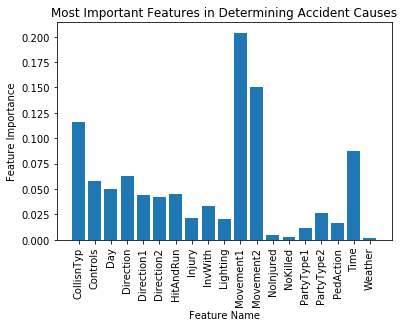

In [62]:
feature_importances = xgb.feature_importances_
arr = []
j = 0
for key in lenEncodeDic:
    total = 0
    for i in range(lenEncodeDic[key]):
        total += feature_importances[j]
        j += 1
    arr.append((key, total))
arr.sort(key=lambda x: -x[1])
xArr = [None]*len(arr)
yArr = [None]*len(arr)
for i in range(len(arr)):
    xArr[i] = arr[i][0]
    yArr[i] = arr[i][1]
plt.bar(xArr, yArr)
plt.xticks(rotation='vertical')
plt.title("Most Important Features in Determining Accident Causes")
plt.ylabel("Feature Importance")
plt.xlabel("Feature Name")
plt.show()
# plot_importance(xgb)
# pyplot.show()

In [ ]:
# See TODO in predictUnknownCauses function
unknownCausePredictions = predictUnknownCauses(xgb, df, decodeDic)

In [ ]:
# The following 3 lines prints the num of unique values for each feature
# for column in df2:
#     print(column)
#     print(len(pd.value_counts(df2[column])))
df

In [ ]:
# Testing onehot encoding and decoding
a = roundTime(df4['Time'])[:10]
print(a)
encoded, le, _ = onehot_encode(a)
print(encoded)
print(onehot_encode(encoded, label_encoder=le))

In [ ]:
getSortedCauses(df)

In [ ]:
# Analysis on Time of Day vs Pedestrian Involved
df5 = df.drop(['OBJECTID', 'Accidno', 'Date', 'Street', 'CrossSt', 'X', 'Y', 'PtyAtFault', 
                   'PvtProp', 'Violation', 'PartyAge1', 'PartySex1', 'SafetyEq1', 'PartyAge2', 
                   'PartySex2', 'SafetyEq2', 'Distance'], axis=1)
df5 = filterData(df5).dropna()
roundedTimes = roundTime(df5['Time'])
# print(roundedTimes)
agg = [0]*24
i = 0
for index, row in df5.iterrows():
    if "No Pedestrian Involved" not in row['PedAction']:
        idx = int(roundedTimes[i].split(':')[0])
        agg[(idx + 0) % 24] += 1
    i += 1

xLabels = range(24)
print(agg)
plt.plot(xLabels, agg)
plt.ylabel("Pedestrian Involved In Accident")
plt.xlabel("Time of Day")
plt.show()